# Import Libraries

In [2]:
import os
import json
import optuna
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})
torch.random.manual_seed(1904)

%matplotlib inline
%load_ext autoreload
%autoreload 2

os.makedirs('results', exist_ok=True)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

# Manually Tuned Constants

In [3]:
BATCH_SIZE = 64
N_EPOCHS = 20
OPTUNA_STUDY_N_TRIALS = 20  # number of trials for tuning hyperparameters using optuna

# Get and Prepare Data

In [6]:
from torch.utils.data import random_split

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
    ])

train_set = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

ds_train, ds_valid = random_split(train_set, [0.8, 0.2], generator=torch.Generator().manual_seed(42))

dl_train = DataLoader(
    ds_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
    )

dl_valid = DataLoader(
    ds_valid,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
    )

ds_test = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

dl_test = DataLoader(
    ds_test,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
    )

n_classes = 10
n_features = ds_train[0][0].flatten().shape[0]

## Plot random samples

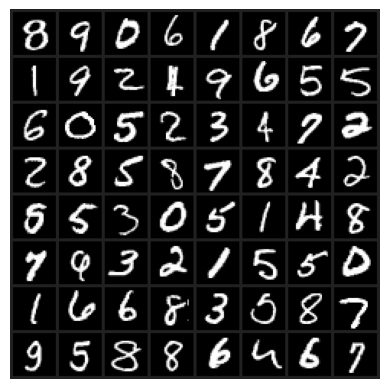

True Labels
[8, 9, 0, 6, 1, 8, 6, 7]
[1, 9, 2, 4, 9, 6, 5, 5]
[6, 0, 5, 2, 3, 4, 7, 2]
[2, 8, 5, 8, 7, 8, 4, 2]
[5, 5, 3, 0, 5, 1, 4, 8]
[7, 9, 3, 2, 1, 5, 5, 0]
[1, 6, 6, 8, 3, 5, 8, 7]
[9, 5, 8, 8, 6, 4, 6, 7]


In [7]:
def imshow(img):
    img = img * 0.3081 + 0.1307     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


# get some random training images
images, labels = next(iter(dl_train))
imshow(torchvision.utils.make_grid(images))

print('True Labels')
for i in range(8):
    print(labels[i*8:(i+1)*8].tolist())


In [6]:
from utils import MLP

# Example of the MLP model with the given architecture
example_model = MLP(
    n_features=n_features,
    n_targets=n_classes,
    hidden_dim=1024,
    n_layers=3,
    dropout=0.3
)

example_model

MLP(
  (sequencial): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=1024, out_features=10, bias=True)
    (13): Softmax(dim=1)
  )
)

# Hyperparameter Tuning for the MLP model and Trainer

## Setup

In [10]:
from utils import Trainer

def run_training(params_grid, tuning=False, save_model=False):
    model = MLP(
        n_features=n_features,
        n_targets=n_classes,
        hidden_dim=params_grid['hidden_dim'],
        n_layers=params_grid['n_layers'],
        dropout=params_grid['dropout']
    ).to(DEVICE)
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        params=model.parameters(), 
        lr=params_grid['lr'],
        weight_decay=params_grid['weight_decay']
        )
    
    trainer = Trainer(model, loss_fn, optimizer, DEVICE)
    fit_res = trainer.fit(
        dl_train,
        dl_valid,
        save_model,
        num_epochs=N_EPOCHS,
        early_stopping=5,
        print_every=N_EPOCHS//2
        )
    
    return fit_res.best_loss if tuning else fit_res


def objective(trial: optuna.trial.Trial):
    params_grid = {
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'hidden_dim': trial.suggest_categorical('hidden_dim', [64, 128, 256, 512]),
        'dropout': trial.suggest_float('dropout', 0.1, 0.5, step=0.1),
        'lr': trial.suggest_float('lr', 1e-6, 1e-3, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-3, 1e-1),
    }
    
    loss = run_training(params_grid, tuning=True)
    return loss

## Run Tuning

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=OPTUNA_STUDY_N_TRIALS)

[I 2024-09-09 23:13:01,433] A new study created in memory with name: no-name-3e26cf90-1290-47d9-86dd-6efee9f9b321


--- EPOCH 1/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

--- EPOCH 11/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

--- EPOCH 20/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2024-09-09 23:26:50,334] Trial 0 finished with value: 1.621258331740156 and parameters: {'n_layers': 3, 'hidden_dim': 256, 'dropout': 0.4, 'lr': 7.931993498971988e-06, 'weight_decay': 0.09151480435485974}. Best is trial 0 with value: 1.621258331740156.


--- EPOCH 1/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

--- EPOCH 11/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2024-09-09 23:35:08,238] Trial 1 finished with value: 1.8672805422164025 and parameters: {'n_layers': 2, 'hidden_dim': 64, 'dropout': 0.30000000000000004, 'lr': 3.671501726355531e-05, 'weight_decay': 0.07893286882306366}. Best is trial 0 with value: 1.621258331740156.


--- EPOCH 1/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

--- EPOCH 11/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

--- EPOCH 20/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2024-09-09 23:47:56,359] Trial 2 finished with value: 2.1076737337924065 and parameters: {'n_layers': 3, 'hidden_dim': 128, 'dropout': 0.4, 'lr': 1.7120655727453019e-06, 'weight_decay': 0.09114953132602319}. Best is trial 0 with value: 1.621258331740156.


--- EPOCH 1/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

--- EPOCH 11/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

--- EPOCH 20/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2024-09-10 00:00:59,622] Trial 3 finished with value: 1.9311345726885694 and parameters: {'n_layers': 3, 'hidden_dim': 256, 'dropout': 0.5, 'lr': 2.0543076248507706e-06, 'weight_decay': 0.05035906789718504}. Best is trial 0 with value: 1.621258331740156.


--- EPOCH 1/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

--- EPOCH 11/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

--- EPOCH 20/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2024-09-10 00:13:19,780] Trial 4 finished with value: 1.9482381109227525 and parameters: {'n_layers': 2, 'hidden_dim': 128, 'dropout': 0.4, 'lr': 2.3547614924255273e-06, 'weight_decay': 0.09141038120187268}. Best is trial 0 with value: 1.621258331740156.


--- EPOCH 1/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2024-09-10 00:17:08,179] Trial 5 finished with value: 1.6312351765784812 and parameters: {'n_layers': 3, 'hidden_dim': 512, 'dropout': 0.4, 'lr': 0.0006740039242729296, 'weight_decay': 0.04838726175314483}. Best is trial 0 with value: 1.621258331740156.


--- EPOCH 1/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

--- EPOCH 11/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

--- EPOCH 20/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2024-09-10 00:30:02,355] Trial 6 finished with value: 1.5401724500859038 and parameters: {'n_layers': 2, 'hidden_dim': 512, 'dropout': 0.30000000000000004, 'lr': 4.40529503477701e-06, 'weight_decay': 0.03942452295621471}. Best is trial 6 with value: 1.5401724500859038.


--- EPOCH 1/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

--- EPOCH 11/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2024-09-10 00:37:34,613] Trial 7 finished with value: 1.5818280114772472 and parameters: {'n_layers': 2, 'hidden_dim': 128, 'dropout': 0.1, 'lr': 4.0956200034143545e-05, 'weight_decay': 0.05106314335087383}. Best is trial 6 with value: 1.5401724500859038.


--- EPOCH 1/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

--- EPOCH 11/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

--- EPOCH 20/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2024-09-10 00:49:45,057] Trial 8 finished with value: 1.9167490848835478 and parameters: {'n_layers': 2, 'hidden_dim': 256, 'dropout': 0.5, 'lr': 1.6478542348567293e-06, 'weight_decay': 0.07108455342280863}. Best is trial 6 with value: 1.5401724500859038.


--- EPOCH 1/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

--- EPOCH 11/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2024-09-10 00:59:32,063] Trial 9 finished with value: 1.5278514560232772 and parameters: {'n_layers': 2, 'hidden_dim': 256, 'dropout': 0.2, 'lr': 2.485561017168195e-05, 'weight_decay': 0.03716329550392297}. Best is trial 9 with value: 1.5278514560232772.


--- EPOCH 1/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

--- EPOCH 11/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2024-09-10 01:08:25,595] Trial 10 finished with value: 1.5962513932522306 and parameters: {'n_layers': 1, 'hidden_dim': 64, 'dropout': 0.1, 'lr': 0.0002045048767288493, 'weight_decay': 0.004533160579691664}. Best is trial 9 with value: 1.5278514560232772.


--- EPOCH 1/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

--- EPOCH 11/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

--- EPOCH 20/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2024-09-10 01:20:57,666] Trial 11 finished with value: 1.5700508127821253 and parameters: {'n_layers': 1, 'hidden_dim': 512, 'dropout': 0.2, 'lr': 1.1411623267556919e-05, 'weight_decay': 0.023170451088077023}. Best is trial 9 with value: 1.5278514560232772.


--- EPOCH 1/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

--- EPOCH 11/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

--- EPOCH 20/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2024-09-10 01:33:16,836] Trial 12 finished with value: 1.5797709359767589 and parameters: {'n_layers': 1, 'hidden_dim': 512, 'dropout': 0.2, 'lr': 7.54183584658748e-06, 'weight_decay': 0.031429956507483404}. Best is trial 9 with value: 1.5278514560232772.


--- EPOCH 1/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2024-09-10 01:39:00,909] Trial 13 finished with value: 1.5239267152674654 and parameters: {'n_layers': 2, 'hidden_dim': 512, 'dropout': 0.2, 'lr': 0.00010097453037082469, 'weight_decay': 0.031080007369760007}. Best is trial 13 with value: 1.5239267152674654.


--- EPOCH 1/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2024-09-10 01:44:24,782] Trial 14 finished with value: 1.5244434488580583 and parameters: {'n_layers': 2, 'hidden_dim': 256, 'dropout': 0.2, 'lr': 0.00011733347069918274, 'weight_decay': 0.014470618301881837}. Best is trial 13 with value: 1.5239267152674654.


--- EPOCH 1/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2024-09-10 01:49:07,053] Trial 15 finished with value: 1.5856570449281246 and parameters: {'n_layers': 1, 'hidden_dim': 256, 'dropout': 0.2, 'lr': 0.00012749664178418453, 'weight_decay': 0.009157486034285713}. Best is trial 13 with value: 1.5239267152674654.


--- EPOCH 1/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2024-09-10 01:53:33,106] Trial 16 finished with value: 1.5250702208661018 and parameters: {'n_layers': 2, 'hidden_dim': 512, 'dropout': 0.1, 'lr': 0.00015958850836449897, 'weight_decay': 0.01895951578299189}. Best is trial 13 with value: 1.5239267152674654.


--- EPOCH 1/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2024-09-10 01:57:02,444] Trial 17 finished with value: 1.7425959845806689 and parameters: {'n_layers': 1, 'hidden_dim': 64, 'dropout': 0.30000000000000004, 'lr': 0.0006532892361830092, 'weight_decay': 0.01911620450095955}. Best is trial 13 with value: 1.5239267152674654.


--- EPOCH 1/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2024-09-10 02:02:26,570] Trial 18 finished with value: 1.5573523583564353 and parameters: {'n_layers': 2, 'hidden_dim': 256, 'dropout': 0.2, 'lr': 7.363137168153887e-05, 'weight_decay': 0.06453352419026467}. Best is trial 13 with value: 1.5239267152674654.


--- EPOCH 1/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

--- EPOCH 11/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2024-09-10 02:14:11,511] Trial 19 finished with value: 1.4884715765080554 and parameters: {'n_layers': 3, 'hidden_dim': 512, 'dropout': 0.1, 'lr': 0.0003778936098941074, 'weight_decay': 0.001170783180603839}. Best is trial 19 with value: 1.4884715765080554.


## Best Results

In [49]:
best_trial = study.best_trial
print('Best Trial:')
print('\t', best_trial.values)
print('\t', best_trial.params)

with open('results/best_trial_params.json', 'w') as f:
    json.dump(best_trial.params, f, indent=4)

Best Trial:
	 [1.4884715765080554]
	 {'n_layers': 3, 'hidden_dim': 512, 'dropout': 0.1, 'lr': 0.0003778936098941074, 'weight_decay': 0.001170783180603839}


# Build Best Model and Save it

In [13]:
fit_result = run_training(best_trial.params, save_model=True)

--- EPOCH 1/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]


*** Saved best model


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]


*** Saved best model


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]


*** Saved best model


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]


*** Saved best model


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]


*** Saved best model


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]


*** Saved best model


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]


*** Saved best model


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]


*** Saved best model
--- EPOCH 11/20 ---


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]


*** Saved best model


train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

train_batch:   0%|          | 0/750 [00:00<?, ?it/s]

test_batch:   0%|          | 0/188 [00:00<?, ?it/s]

## Plot best model training results

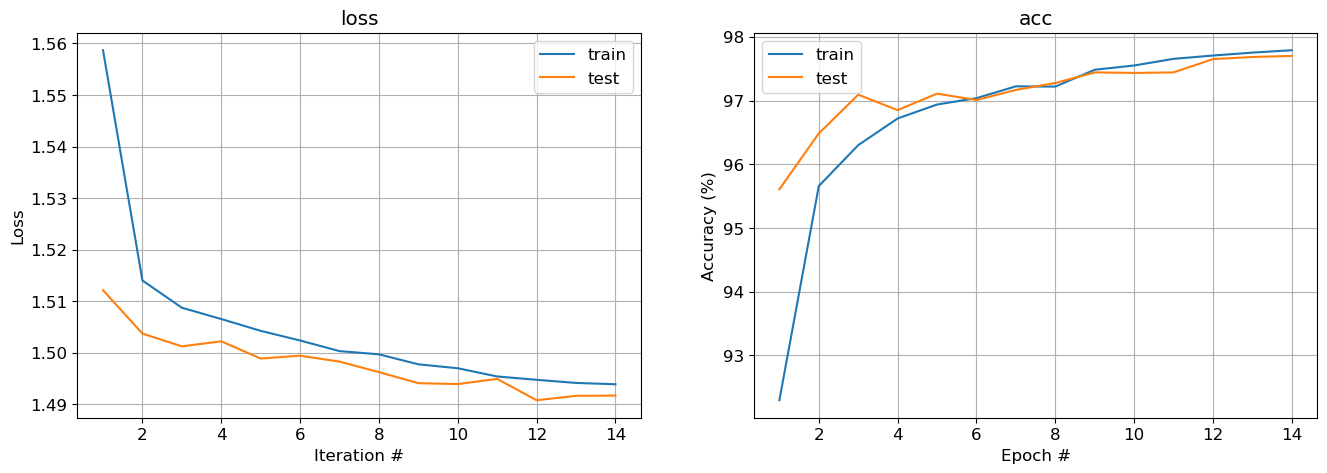

In [43]:
from utils import plot_fit

plot_fit(fit_result, log_loss=False, train_test_overlay=True)
plt.show()

## Load best model

In [16]:
best_model: nn.Module = torch.jit.load('results/best_model_script.pt')
best_model.to(DEVICE)
best_model.eval()
best_model

RecursiveScriptModule(
  original_name=MLP
  (sequencial): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=BatchNorm1d)
    (2): RecursiveScriptModule(original_name=Dropout)
    (3): RecursiveScriptModule(original_name=ReLU)
    (4): RecursiveScriptModule(original_name=Linear)
    (5): RecursiveScriptModule(original_name=BatchNorm1d)
    (6): RecursiveScriptModule(original_name=Dropout)
    (7): RecursiveScriptModule(original_name=ReLU)
    (8): RecursiveScriptModule(original_name=Linear)
    (9): RecursiveScriptModule(original_name=BatchNorm1d)
    (10): RecursiveScriptModule(original_name=Dropout)
    (11): RecursiveScriptModule(original_name=ReLU)
    (12): RecursiveScriptModule(original_name=Linear)
    (13): RecursiveScriptModule(original_name=Softmax)
  )
)

# Test Best Model on Unseen Data

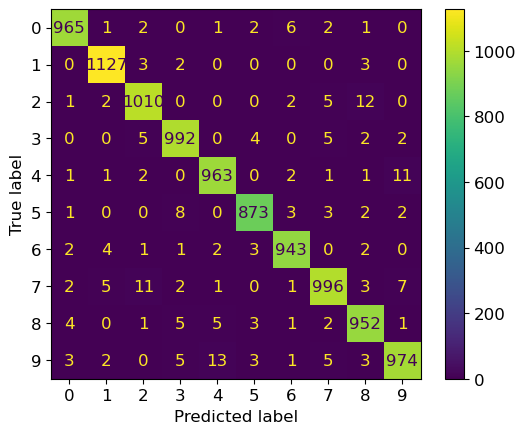

Accuracy for class 0 is 98.47 %
Accuracy for class 1 is 99.30 %
Accuracy for class 2 is 97.87 %
Accuracy for class 3 is 98.22 %
Accuracy for class 4 is 98.07 %
Accuracy for class 5 is 97.87 %
Accuracy for class 6 is 98.43 %
Accuracy for class 7 is 96.89 %
Accuracy for class 8 is 97.74 %
Accuracy for class 9 is 96.53 %


In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, accuracy_score

true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in dl_test:
        X, y = batch
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        
        y_pred_scores = best_model(X)
        y_pred = torch.argmax(y_pred_scores, dim=1)
        
        true_labels.extend(y.cpu().numpy())
        predicted_labels.extend(y_pred.cpu().numpy())
        

# Plot confusion matrix
cnf_matrix = confusion_matrix(true_labels, predicted_labels)
labels = np.arange(n_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=labels)
disp.plot()
plt.show()

results = []
total_accuracy = {'Total Accuracy': accuracy_score(true_labels, predicted_labels).round(4)}

recall_scores_dict = {}
recall_scores = recall_score(true_labels, predicted_labels, average=None).round(4)
for label, score in enumerate(recall_scores):
    recall_scores_dict[f'Label {label} Accuracy'] = score
    print(f"Accuracy for class {label} is {score*100:.2f} %")
    
results.append(total_accuracy)
results.append(recall_scores_dict)
with open('results/test_set_results.json', 'w') as f:
    json.dump(results, f, indent=4)